# Загрузка Pandas и очистка данных

In [323]:
import pandas as pd
from afinn import Afinn
import re
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from collections import Counter
from datetime import datetime
import requests
from bs4 import BeautifulSoup

In [331]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0
df = df_test.append(df_train, sort=False).reset_index(drop=True)

# Данные полученные с помощью парсинга функцией new_features страниц типа https://www.tripadvisor.com/UpdateListing-d12516716
new_feature = pd.read_csv('new_feature_1.csv')

In [332]:
# Функция для парсинга страниц типа https://www.tripadvisor.com/UpdateListing-d12516716 с помощью данных из колонки ID_TA (df.ID_TA.apply(new_features))
def new_features(x):
    url = 'https://www.tripadvisor.com/UpdateListing-' + x
    r = requests.get(url)
    soup = BeautifulSoup(r.text)
    feachers_list = []
    for i in soup.select('.inline'):
        feachers_list.append(str(i))
    if len(feachers_list) != 0:
        special_list = []
        for i in feachers_list:
            if 'dining_options' in i and 'checked' in i:
                spec = re.search(r'\"\>([^\/[\]]+)\<\/', i)[0][2:-2]
                special_list.append(spec)
        if len(special_list) != 0:
            return special_list
        else:
            return None
    else:
        return None


# Функция для формирования признаков из new_feature
def find_item_2(cell):
    if type(cell) != float:
        if item in cell:
            return 1
        else:
            return 0
    else:
        return 0

# Функция для формирования признаков из Cuisine Style


def find_item(cell):
    if item in cell:
        return 1
    return 0


def city_rest(city):
    return city_group[city]


def rev_std_city(city):
    return city_rev_mean[city]

In [ ]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [333]:
# Добавляем признаки полученные с помощью парсинга старниц сайта
df['new'] = new_feature
df.new = df.new.apply(
    lambda x: x if pd.isnull(x) else eval(x))
new_f = df.new.explode().unique()
# Признак показывает какие специальные предложения имеет ресторан
for item in new_f:
    df[item] = df.new.apply(find_item_2)
# Признак показывает количество специальных предложений ресторана
df['count_new'] = df['new'].apply(lambda x: 0 if type(x) == float else len(x))
df[['Rating','count_new']].corr()

In [327]:
# Признак отношения ресторна к опреденному городу
df = pd.concat([df, pd.get_dummies(df.City)], axis=1)

In [338]:
# Заполняем пропуски в колонке Cuisine Style основываясь на принадлежности ресторана к опреденному городу:
# среднему количеству кухонь в реторанах города и самым популярным видам кухонь в городе
df['Cuisine Style'] = df['Cuisine Style'].apply(
    lambda x: x if pd.isnull(x) else eval(x))

for y, x in df.groupby('City')['Cuisine Style']:
    median_cuisin_len = int(x[~x.isna()].apply(lambda z: len(z)).median())
    nan_len = df[df['City'] == y]['Cuisine Style'].isna().sum()
    nan_replace = pd.Series([list(x.explode().value_counts(
    )[:median_cuisin_len].index) for item in range(nan_len)])
    nan_place_index = df[(df['City'] == y) & (
        df['Cuisine Style'].isna() == True)]['Cuisine Style'].index
    df.loc[nan_place_index, 'Cuisine Style'] = nan_replace.values

# ]Признак количества кухонь в ресторане
df['cuisine_style_len'] = df['Cuisine Style'].apply(lambda x: len(x))


# Признак наличия той или иной кухни в ресторане
cuisine = df['Cuisine Style'].explode().unique()

for item in cuisine:
    df[item] = df['Cuisine Style'].apply(find_item)
df[['Rating','cuisine_style_len']].corr()

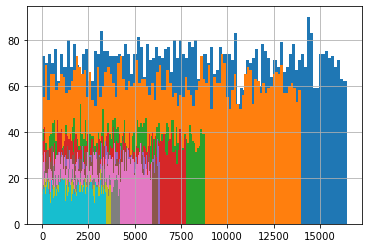

In [328]:
# Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [340]:
df[['Rating','Ranking']].corr()

,Rating,Ranking
Rating,1.000000,-0.109897
Ranking,-0.109897,1.000000


In [341]:
#Делаем распредение рангов в городах равномерным
for x, y in df.groupby('City')['Ranking']:
    gg = y.sort_values()
    tt = pd.Series([x for x in range(1, len(gg)+1)], index=gg.index).sort_index()
    df.loc[y.index, 'Ranking'] = tt.values
    
# Распределяем ранги ресторанов на одной шкале от 1 до 7193 (7193 это количестсво ресторанов в Лондоне)
for x in df.City.unique():
    df.loc[df.City == x, 'Ranking'] = pd.cut(df[df.City == x]['Ranking'], 7193, labels=[x for x in range(1, 7194)])
df.Ranking = df.Ranking.astype(float)

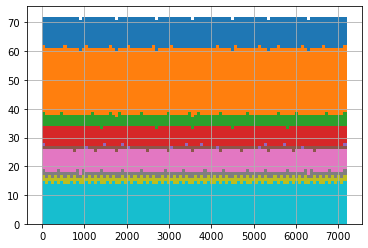

In [330]:
#Убрали смещение
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [342]:
df[['Rating','Ranking']].corr()

,Rating,Ranking
Rating,1.000000,-0.168648
Ranking,-0.168648,1.000000


In [343]:
# Добавялем признаки: соотноешние ранга к количеству ресторанов в городе
city_group = df.groupby('City').size()
def city_rest(city):
    return city_group[city]
df['restoran_count'] = df.City.apply(city_rest)
df['restoran_count_ranking'] = df['Ranking'] / df['restoran_count']
df[['Rating', 'restoran_count_ranking']].corr()

In [347]:
# Добавялем признаки: соотноешние ранга к количеству отзывов о ресторане.
df['restoran_count_rev'] = df['Ranking'] / df['Number of Reviews']
df[['Rating', 'restoran_count_rev']].corr()

In [349]:
# Добавляем признак тональности отзывов
afinn = Afinn(language='en')
text_reviews = df['Reviews'].apply(lambda x: 0 if x ==
                    '[[], []]' else 0 if type(x) == float else re.findall(r'\[([^\/[\]]+)\]', x))
text_reviews_1 = text_reviews.apply(lambda x: x if x==0 else 0 if x==[] else x[0][1:-1])
text_reviews_1=text_reviews_1.apply(lambda x: x if x == 0 else x.replace("', '", ' '))
df['reviews_score'] = text_reviews_1.apply(lambda x: x if x==0 else afinn.score(x))
df[['Rating', 'reviews_score']].corr()

In [352]:
# Добавляем признак количества дней от последнего отзыва
date_reviews = df['Reviews'].dropna().apply(lambda x: re.findall(r'\d\d\/\d\d\/\d{4}', x))
df['last_rev'] = pd.to_datetime(date_reviews.apply(lambda x: x[1] if len(x) == 2 else x[0] if len(x) == 1 else None))
df['last_rev'].fillna(df['last_rev'].min(), inplace=True)
current_datetime = datetime.now()
df['days_dfom_last_rev'] = (current_datetime - df['last_rev'])
df['days_dfom_last_rev'] = df['days_dfom_last_rev'].apply(lambda x: x.days)
df[['Rating', 'days_dfom_last_rev']].corr()

In [354]:
# Если превратить эту колонку в ичловую то она тоже неплохо помагает в предсказании оценки
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))
df[['Rating', 'ID_TA']].corr()

,Rating,ID_TA
Rating,1.000000,0.049589
ID_TA,0.049589,1.000000


In [355]:
#Добавялем данные о популяции в городах и формируем признаки:
# количество людей в городе на один ресторан
# количество людей в городе на 1 отзыв
population = {
 'London': 8788,
 'Paris': 10958,
 'Madrid': 6559,
 'Barcelona': 5541,
 'Berlin': 3557,
 'Milan': 3136,
 'Rome': 4234,
 'Prague': 1319,
 'Lisbon': 2942,
 'Vienna': 1915,
 'Amsterdam': 1140,
 'Brussels': 2065,
 'Hamburg': 1791,
 'Munich': 1521,
 'Lyon': 1705,
 'Stockholm': 974,
 'Budapest': 1764,
 'Warsaw': 1776,
 'Dublin': 1215,
 'Copenhagen': 1334,
 'Athens': 3154,
 'Edinburgh': 531,
 'Zurich': 1383,
 'Oporto': 238,
 'Geneva': 202,
 'Krakow': 1832,
 'Oslo': 1020,
 'Helsinki': 1292,
 'Bratislava': 426,
 'Luxembourg': 614,
 'Ljubljana': 284,
}
df['population'] = df['City'].map(population)

df['people_per_res'] = df['population'] / df['restoran_count']
df['people_per_rev'] = df['population'] / df['Number of Reviews']

df[['Rating', 'people_per_res', 'people_per_rev']].corr()

,Rating,people_per_res,people_per_rev
Rating,1.000000,0.008247,-0.005336
people_per_res,0.008247,1.000000,0.046912
people_per_rev,-0.005336,0.046912,1.000000


In [356]:
# Признак отклнение от среднего количества отзывов в городе
city_rev_mean = df.groupby('City')['Number of Reviews'].mean()
def rev_std_city(city):
    return city_rev_mean[city]
df['rev_std'] = df['Number of Reviews'] - df.City.apply(rev_std_city)
df[['Rating', 'rev_std']].corr()

,Rating,rev_std
Rating,1.000000,0.008928
rev_std,0.008928,1.000000


In [317]:
# Признак уровня цен в ресторанах
df['Price Range 1-3'] = df['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$' else x)
df['Price Range 1-3'].fillna(df['Price Range 1-3'].median(), inplace=True)

In [360]:
# Очистка данных
df = df.drop(['City', 'Cuisine Style', 'Reviews',
              'URL_TA', 'Price Range', 'last_rev', 'population', 'restoran_count', 'new'], axis=1)
df = df.apply(lambda x: x.fillna(0) if x.dtype == 'float64' else x)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [361]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['Restaurant_id', 'Rating'], axis = 1)

y = train_data['Rating']


In [14]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [363]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


# Создаём, обучаем и тестируем модель

In [16]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [364]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [322]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))


MAE: 0.19873749999999998


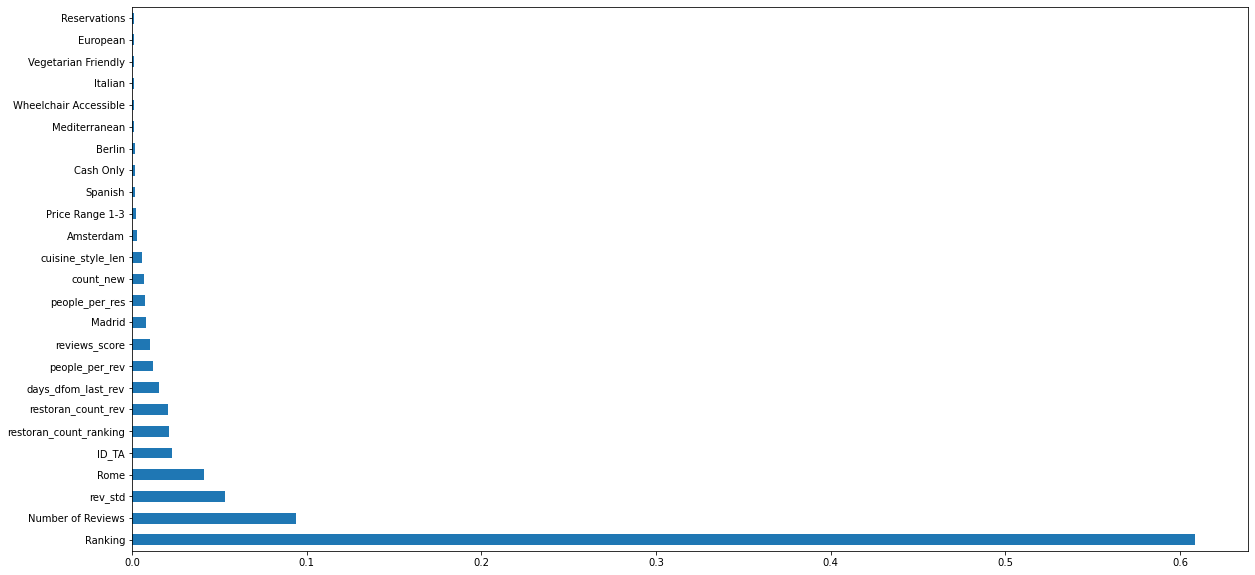

In [240]:
plt.rcParams['figure.figsize'] = (20,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

